=> **LDA** (Latent Dirichlet Allocation): é um modelo estatístico usado para descobrir tópicos ocultos em grandes coleções de textos. O LDA assume que cada documento em um conjunto de textos é composto por uma mistura de tópicos e que cada tópico é representado por um conjunto de palavras. Ele funciona assim:

 - Escolhe aleatoriamente um conjunto de tópicos para cada documento.

 - Observa as palavras no documento e ajusta a distribuição de tópicos com base em quais palavras aparecem juntas frequentemente.

 - Após várias iterações, o modelo aprende a associar palavras que pertencem ao mesmo tópico.


In [2]:
import pandas as pd

papers = pd.read_csv("papers.csv")

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
from tqdm.auto import tqdm


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\belch\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\belch\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\belch\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\belch\anaconda3\envs\llm311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from sklearn.feature_extraction.text import CountVectorizer
stop_words = stopwords.words('english')
tqdm.pandas()

def text_cleaner(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    custom_stopwords = set(stopwords.words('english'))
    cleaned_tokens = [token for token in tokens if token not in custom_stopwords]
    cleaned_tokens = [token for token in cleaned_tokens if len(token) > 2]
    return ' '.join(cleaned_tokens)

papers['text_processed'] = papers['paper_text'].progress_apply(text_cleaner)

100%|██████████| 7241/7241 [01:29<00:00, 81.05it/s] 


In [4]:
from sklearn.feature_extraction.text import CountVectorizer

tfidf = CountVectorizer(
    lowercase=True,
    stop_words=stopwords.words('english'),
    min_df=10,
    max_df=0.95,
    max_features=5000
)

tfidf.fit(papers['text_processed'])

papers['tfidf'] = papers['text_processed'].apply(lambda x: tfidf.transform([x]).toarray()[0])



In [35]:
papers['tfidf'] = papers['text_processed'].progress_apply(lambda x: tfidf.transform([x]).toarray()[0])

100%|██████████| 7241/7241 [00:12<00:00, 583.15it/s]


In [5]:
papers['tfidf']

0       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
1       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, ...
2       [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, ...
3       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
4       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                              ...                        
7236    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
7237    [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
7238    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
7239    [0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
7240    [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: tfidf, Length: 7241, dtype: object

In [7]:
# Document-Term Matrix
dtm = pd.DataFrame(papers['tfidf'].to_list(),
                   columns=tfidf.get_feature_names_out())

In [8]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
import numpy as np

lda = LDA(n_components=5, random_state=42).fit(dtm.values)
topics = lda.transform(dtm.values)

In [9]:
def get_model_topics(model, feature_names, n_top_words=5):
    word_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[idx] for idx in top_features_ind]
        word_dict[topic_idx] = top_features
    return pd.DataFrame(word_dict)

get_model_topics(lda, dtm.columns, 10)


,0,1,2,3,4
0,network,algorithm,distribution,model,learning
1,neural,data,algorithm,data,algorithm
2,model,learning,function,models,state
3,input,problem,log,image,policy
4,figure,function,matrix,learning,function
5,time,matrix,data,training,time
6,networks,kernel,probability,images,value
7,neurons,method,theorem,features,problem
8,learning,optimization,model,figure,optimal
9,system,methods,gaussian,use,algorithms


In [10]:
papers['topic'] =  np.argmax(topics, axis=1)

In [11]:
papers['topic']

0       0
1       0
2       0
3       2
4       0
       ..
7236    0
7237    2
7238    0
7239    0
7240    3
Name: topic, Length: 7241, dtype: int64

In [40]:
papers.topic.value_counts()

topic
0    1676
3    1574
2    1537
1    1480
4     974
Name: count, dtype: int64

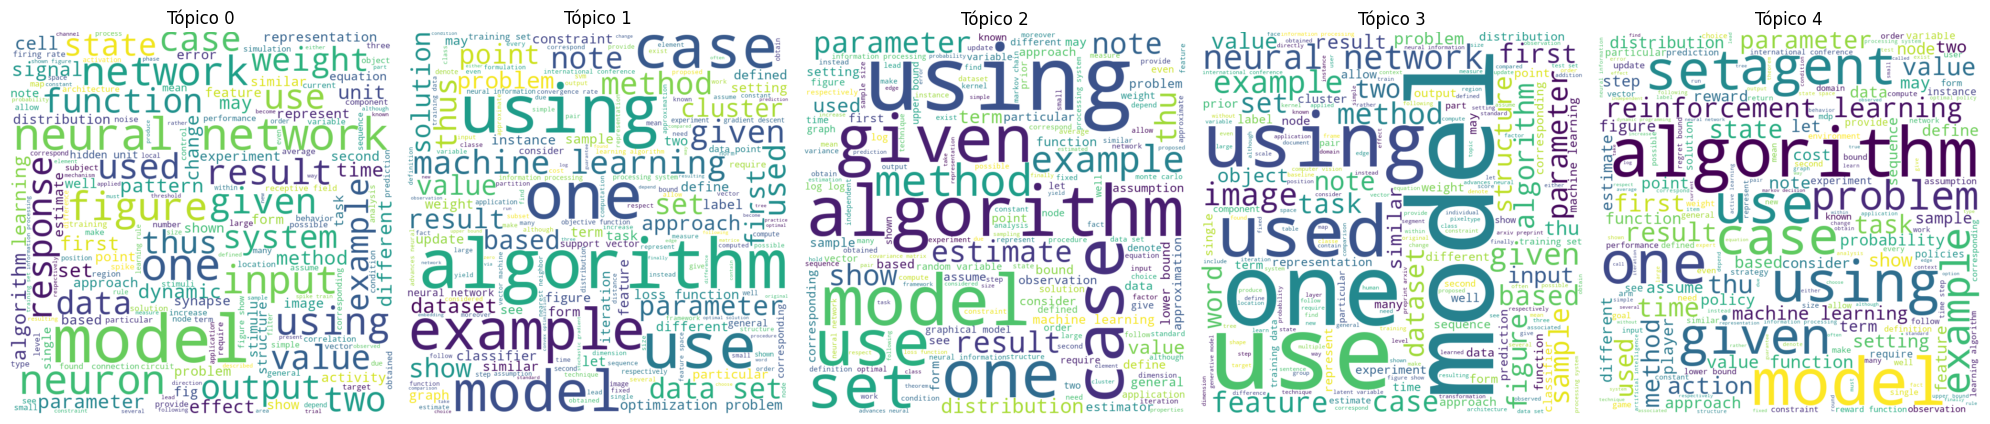

In [12]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt

def draw_all_wordclouds(papers, num_topics=5):
    fig, axes = plt.subplots(1, num_topics, figsize=(20, 5))  # 1 linha, 5 colunas
    
    for i, ax in enumerate(axes):
        texts = ' '.join(papers[papers['topic'] == i]['text_processed'])
        wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(texts)

        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')  # Remove os eixos
        ax.set_title(f"Tópico {i}")

    plt.tight_layout()
    plt.show()

# Chamada da função
draw_all_wordclouds(papers)